## Autoencoders

Autoencoders are build of two networks - __*encoder*__, that encodes data into lower dimensional feature space and __*decoder*__ that tries to reconstruct the input from the encoding. 

![alt text](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

encoder: $X \rightarrow f(X)$ 

decoder: $f(X) \rightarrow g(f(X))$

The objective of the AE is to $min$ ${L(X,g(f(X))}$

Different types of autoencoders are - 
* Vanilla Autoencoder
* Sparse Autoencoder - add sparsity constraint with the loss function s.t. the AE does not learn the trivial function
* Denoising Autoencoder - The loss function changes to $L(X,g(f(\widetilde{X}))$, where $\widetilde{X} = X + \epsilon$ with $\epsilon$ noise. DAE can be used to denoise data. DAE ensures similar images can produce similar output. In a following experiment, I am planning to see if DAE can be used in language model
* Variational Autoencoder - VAE is less AE, more of a generative process, where we encode the data into a particular feature space. With this, we can sample from the feature space and use decoder to generate new data points
* Contractive Autoencoder - In Contractive AE we add $\nabla f(X)$ as regularizer s.t. the encoding of similar data remain similar 

In this notebook I have experimented with different types of Autoencoders using Keras. Most of the codes are from the reference - https://blog.keras.io/building-autoencoders-in-keras.html

In [30]:
from keras.layers import Input, Layer, InputSpec, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Lambda, RepeatVector, Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.metrics import binary_crossentropy, mse, kullback_leibler_divergence
import numpy as np
from keras import regularizers
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD, Adam
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
train = pd.read_csv('data/fashionmnist/fashion-mnist_train.csv')
test = pd.read_csv('data/fashionmnist/fashion-mnist_test.csv')

In [3]:
print (train.shape, test.shape)

(60000, 785) (10000, 785)


In this notebook we will use Fashion MNIST dataset which consists of 70000 images from different fashion items.

In [4]:
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

## normalize and reshape the predictors  
train_x = train_x / 255

## create train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=123)

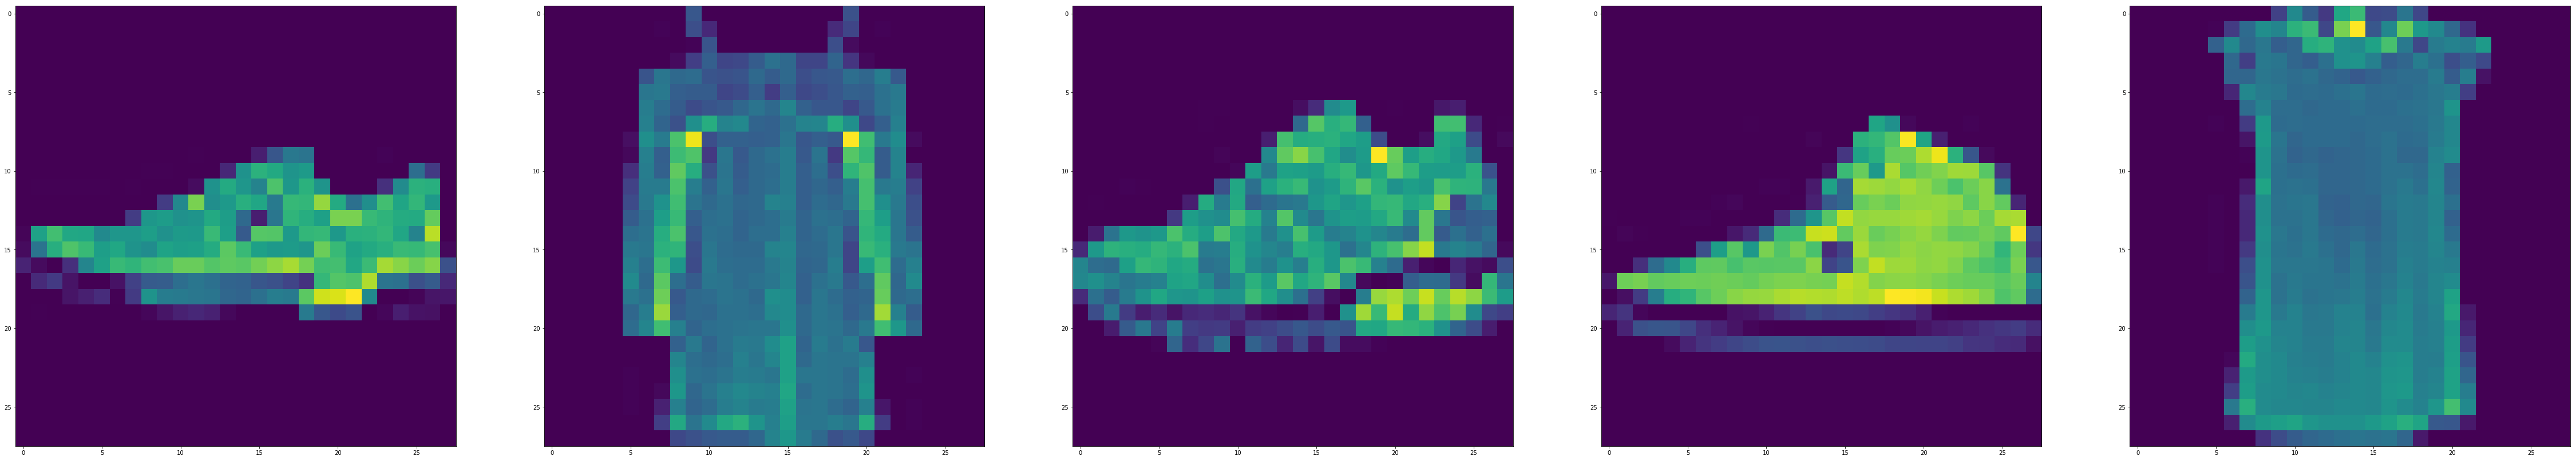

In [5]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(0,5):
    ax[i-5].imshow(train_x[i].reshape(28, 28))
plt.show()

In [6]:
print (len(np.unique(train_y)),len(np.unique(val_y)),test.label.nunique())

10 10 10


First we try vanilla Convolutional autoencoder

In [9]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(28, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(28, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(28, (3, 3), activation='relu', padding='same')(x)
encoded = x

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(28, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(28, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(28, (3, 3), activation='relu',padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
encoder = Model(input_img, Flatten()(encoded))

In [8]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 28)        280       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 28)        7084      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 28)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 28)          7084      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 28)          7084      
__________

In [10]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 28)        280       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 28)        7084      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 28)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 28)          7084      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1372)              0         
Total para

In [21]:
autoencoder.fit(train_x.reshape(len(train_x),28,28,1), train_x.reshape(len(train_x),28,28,1),
                epochs=10,
                batch_size=2048,
                validation_data=(val_x.reshape(len(val_x),28,28,1),val_x.reshape(len(val_x),28,28,1)),
                callbacks=[EarlyStopping(patience=5)])

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 110s 2ms/step - loss: 0.0854 - val_loss: 0.0454
Epoch 2/10
48000/48000 [==============================] - 105s 2ms/step - loss: 0.0341 - val_loss: 0.0273
Epoch 3/10
48000/48000 [==============================] - 96s 2ms/step - loss: 0.0231 - val_loss: 0.0198
Epoch 4/10
48000/48000 [==============================] - 96s 2ms/step - loss: 0.0178 - val_loss: 0.0162
Epoch 5/10
48000/48000 [==============================] - 95s 2ms/step - loss: 0.0150 - val_loss: 0.0141
Epoch 6/10
48000/48000 [==============================] - 94s 2ms/step - loss: 0.0134 - val_loss: 0.0129
Epoch 7/10
48000/48000 [==============================] - 94s 2ms/step - loss: 0.0124 - val_loss: 0.0120
Epoch 8/10
48000/48000 [==============================] - 98s 2ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 9/10
48000/48000 [==============================] - 10

In [22]:
decoded_imgs = autoencoder.predict(val_x.reshape(len(val_x),28,28,1))

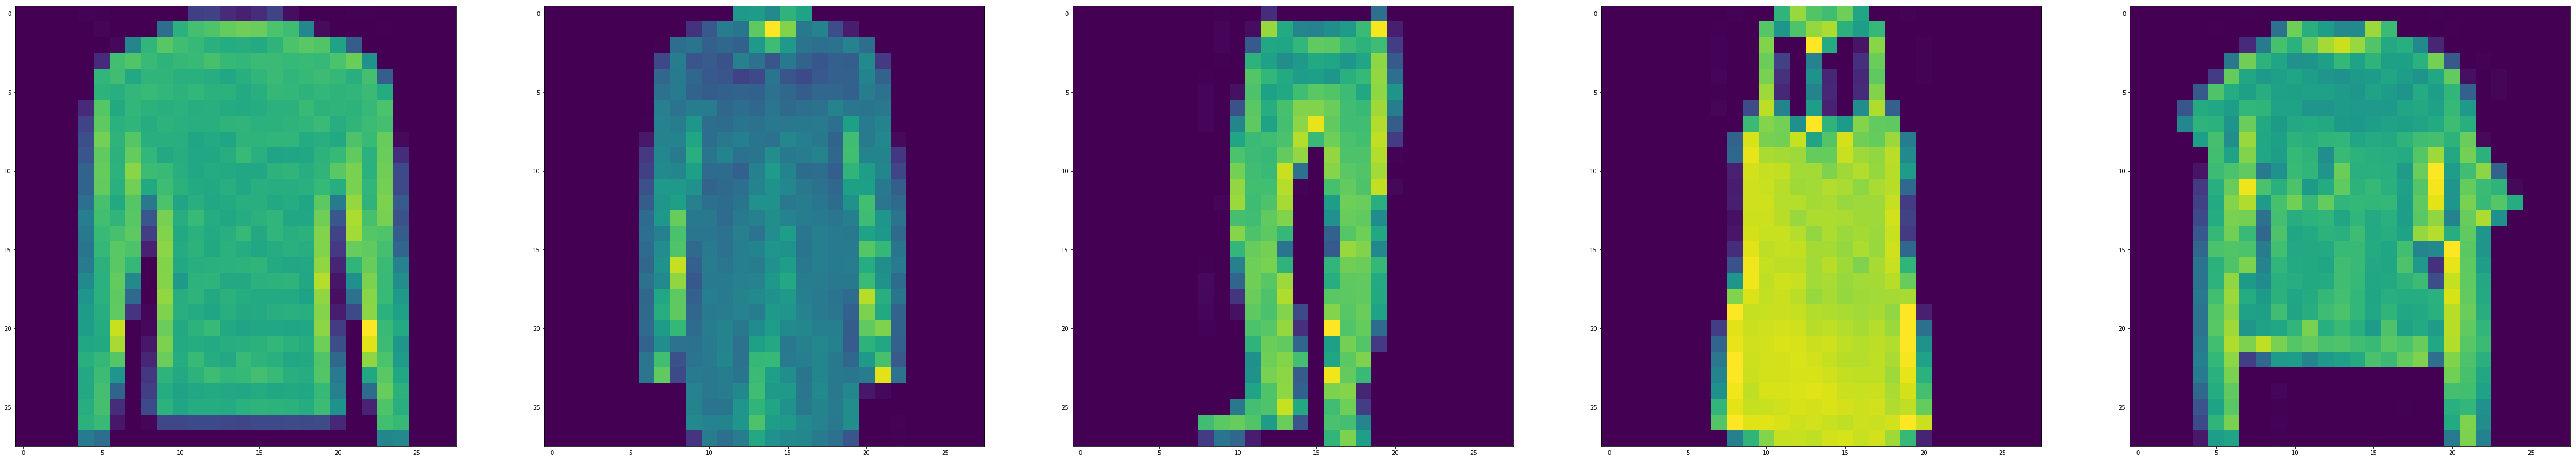

In [23]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(0,5):
    ax[i-5].imshow(val_x[i].reshape(28, 28))
plt.show()

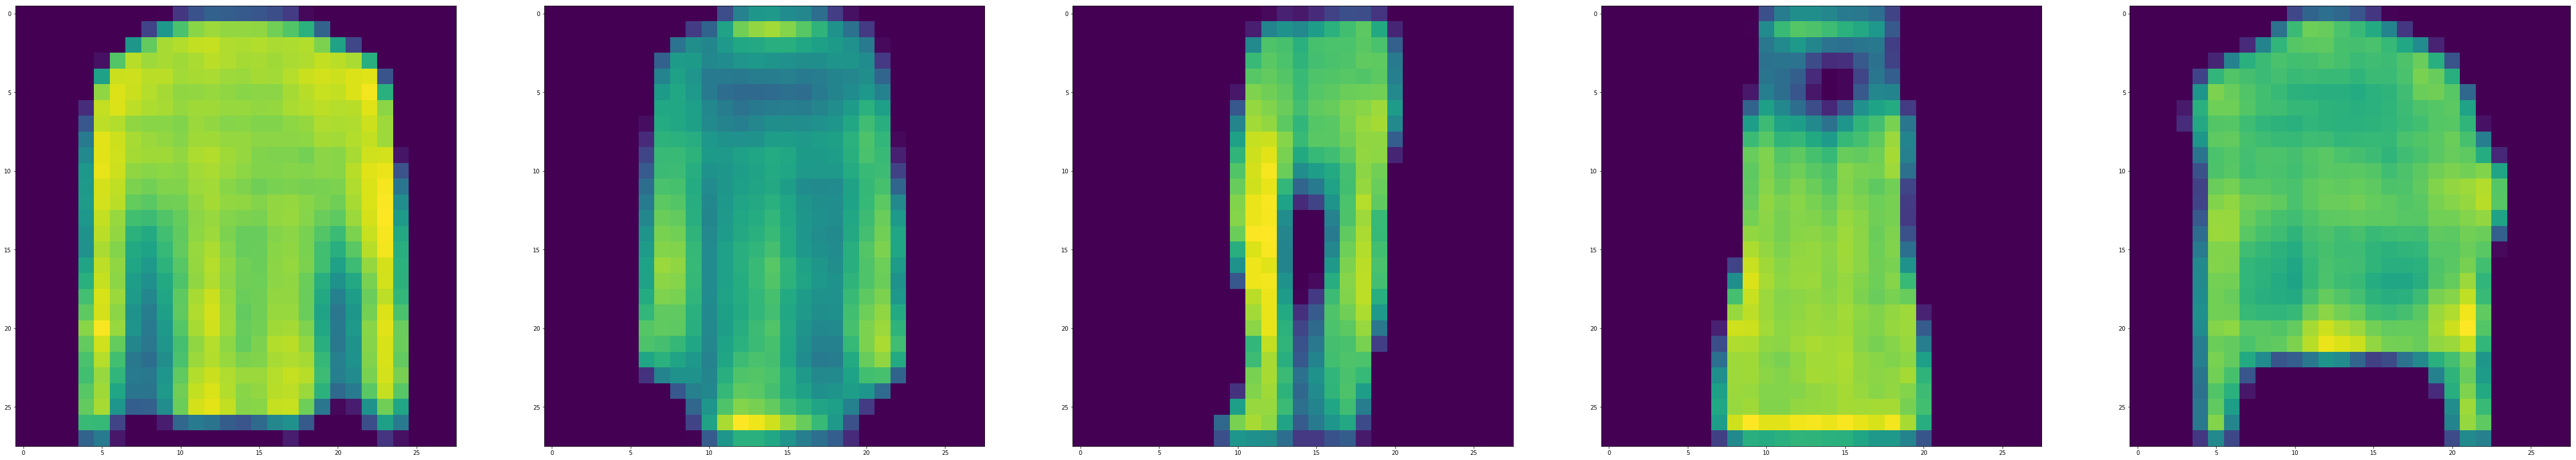

In [24]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(0,5):
    ax[i-5].imshow(decoded_imgs[i].reshape(28, 28))
plt.show()

In [25]:
encoded_imgs = encoder.predict(val_x.reshape(len(val_x),28,28,1))

We visualize the encoder embedding to see how good the representation is. We first use TSNE to get embedding of size 2 and plot the embedding for each of the validation classes

In [28]:
tsne = TSNE(n_components=2,verbose=1)
#reduce = umap.UMAP(random_state = 123) #just for reproducibility
embedding = tsne.fit_transform(encoded_imgs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.729s...
[t-SNE] Computed neighbors for 12000 samples in 167.936s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 0.633416
[t-SNE] KL divergen

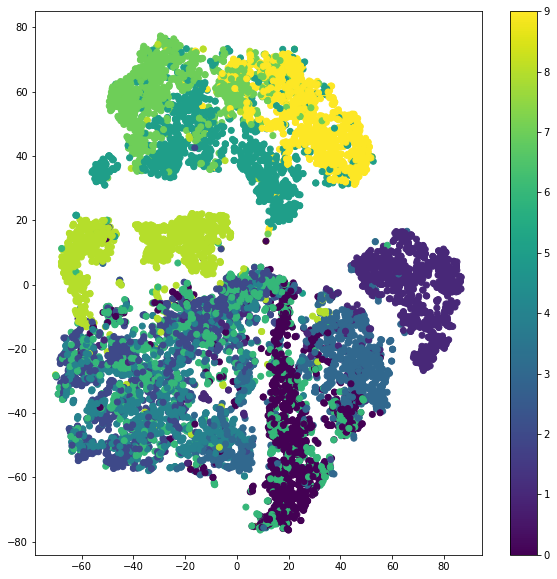

In [29]:
#sns.set_style("whitegrid", {'axes.grid' : False})
#adjusting plot dots with plot_kws
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0],embedding[:,1], c = val_y)
plt.colorbar()
plt.show()

### Deep embedded clustering

Deep embedded clustering combines autoencoders with clustering, resulting into an insightful representation of the dataset. From the above embedding images, we can see that autoencoders alone are not able to differentiate few of the classes. DEC should be able to solve this problem.

This notebook covers deep embedded clustering (DEC) on face images. The paper is - https://arxiv.org/pdf/1511.06335.pdf

The source code is hugely influenced by https://github.com/XifengGuo/DEC-keras/blob/master/DEC.py

In [31]:
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True
        
    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [32]:
n_clusters = 10
alpha = 1

clustering_layer = ClusteringLayer(n_clusters, alpha=alpha, name='clustering')(encoder.output)
DEC = Model(inputs=encoder.input, outputs=clustering_layer) 

DEC.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 28)        280       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 28)        7084      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 28)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 28)          7084      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1372)              0         
__________

In [34]:
def loss(y_true, y_pred):
    weight = y_pred ** 2 / K.sum(y_pred, axis=0)
    y_true = K.transpose(K.transpose(weight) / K.sum(weight, axis=1))
    return kullback_leibler_divergence(y_true, y_pred)

DEC.compile(optimizer=Adam(),loss=loss)

In [36]:
km = KMeans(n_clusters)
km.fit(encoded_imgs)
DEC.get_layer('clustering').set_weights([km.cluster_centers_])

In [37]:
DEC.fit(train_x.reshape(len(train_x),28,28,1), train_y,
                epochs=10,
                batch_size=2048,
                validation_data=(val_x.reshape(len(val_x),28,28,1),val_y),
                callbacks=[EarlyStopping(patience=5)])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 29s 603us/step - loss: 0.0307 - val_loss: 5.0235e-04
Epoch 2/10
48000/48000 [==============================] - 25s 518us/step - loss: 2.0486e-04 - val_loss: 6.6667e-05
Epoch 3/10
48000/48000 [==============================] - 24s 510us/step - loss: 4.2553e-05 - val_loss: 2.5546e-05
Epoch 4/10
48000/48000 [==============================] - 24s 499us/step - loss: 1.9402e-05 - val_loss: 1.3485e-05
Epoch 5/10
48000/48000 [==============================] - 24s 490us/step - loss: 1.0551e-05 - val_loss: 7.3449e-06
Epoch 6/10
48000/48000 [==============================] - 24s 491us/step - loss: 5.7660e-06 - val_loss: 3.9619e-06
Epoch 7/10
48000/48000 [==============================] - 25s 513us/step - loss: 3.1686e-06 - val_loss: 2.1934e-06
Epoch 8/10
48000/48000 [==============================] - 24s 506us/step - loss: 1.8193e-06 - val_loss: 1.3113e-06
Epoch 9/10
48000/48000 [==========

In [41]:
encoded_imgs_dec = encoder.predict(val_x.reshape(len(val_x),28,28,1))
tsne = TSNE(n_components=2,verbose=1)
#reduce = umap.UMAP(random_state = 123) #just for reproducibility
embedding = tsne.fit_transform(encoded_imgs_dec)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.646s...
[t-SNE] Computed neighbors for 12000 samples in 74.963s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 1.772059
[t-SNE] KL divergenc

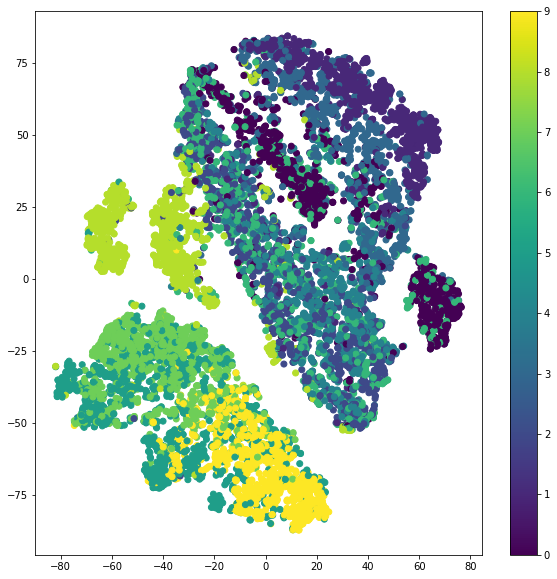

In [42]:
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0],embedding[:,1], c = val_y)
plt.colorbar()
plt.show()

### Denoising auto encoder

Next we add noise to the images. We use imgaug and add salt and pepper noise to all the images.

In [52]:
from imgaug import augmenters

In [62]:
noise = augmenters.SaltAndPepper(.25)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x.reshape(train_x.shape[0],28,28) * 255) / 255
val_x_n = seq_object.augment_images(val_x.reshape(val_x.shape[0],28,28) * 255) / 255

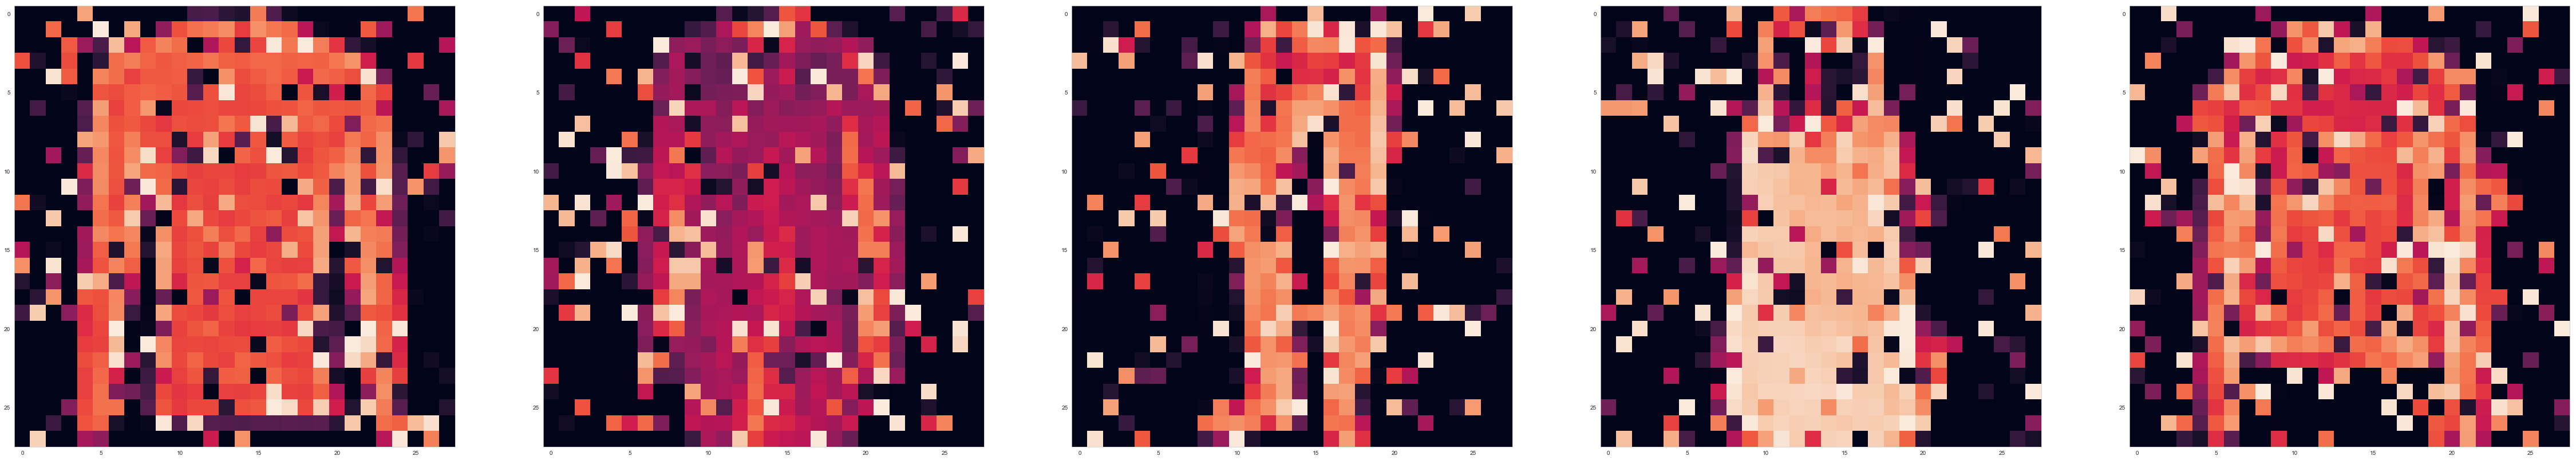

In [63]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(0,5):
    ax[i-5].imshow(val_x_n[i].reshape(28, 28))
plt.show()

In [65]:
autoencoder2 = autoencoder
autoencoder2.fit(train_x_n.reshape(len(train_x_n),28,28,1), train_x.reshape(len(train_x),28,28,1),
                epochs=10,
                batch_size=2048,
                validation_data=(val_x_n.reshape(len(val_x_n),28,28,1),val_x.reshape(len(val_x),28,28,1)),
                callbacks=[EarlyStopping(patience=5)])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 111s 2ms/step - loss: 0.0231 - val_loss: 0.0184
Epoch 2/10
48000/48000 [==============================] - 112s 2ms/step - loss: 0.0172 - val_loss: 0.0165
Epoch 3/10
48000/48000 [==============================] - 102s 2ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 4/10
48000/48000 [==============================] - 102s 2ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 5/10
48000/48000 [==============================] - 105s 2ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 6/10
48000/48000 [==============================] - 101s 2ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 7/10
48000/48000 [==============================] - 105s 2ms/step - loss: 0.0142 - val_loss: 0.0141
Epoch 8/10
48000/48000 [==============================] - 109s 2ms/step - loss: 0.0139 - val_loss: 0.0139
Epoch 9/10
48000/48000 [==============================] - 100s 2ms/step - loss: 0.0136 - val_loss: 0.0

Below we define contractive loss and run AE with updated loss function

In [66]:
decoded_imgs_n = autoencoder2.predict(val_x_n.reshape(len(val_x_n),28,28,1))

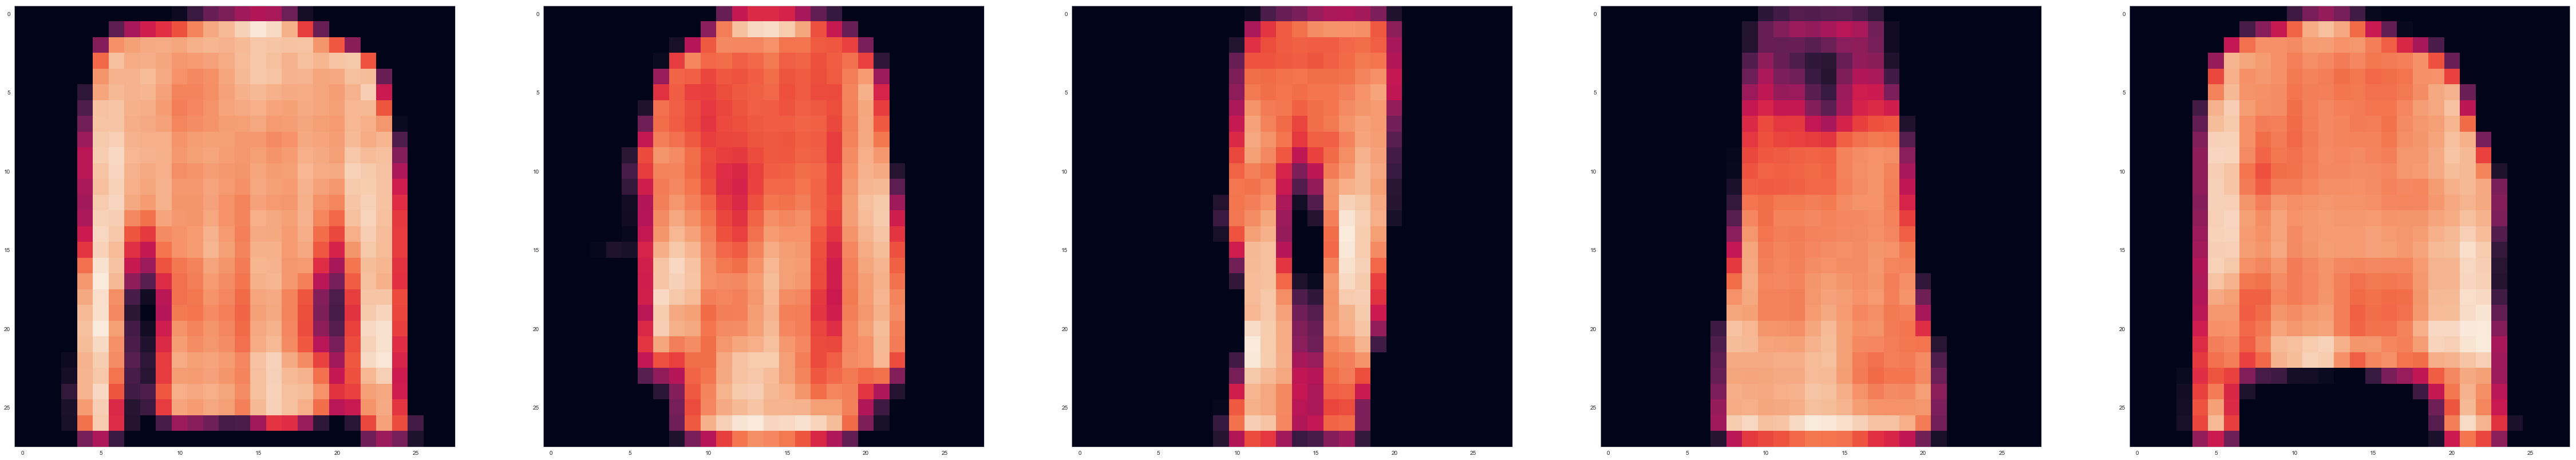

In [67]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(0,5):
    ax[i-5].imshow(decoded_imgs_n[i].reshape(28, 28))
plt.show()

Autoencoder is able to remove the noise from the images.

Next, we remove a part of the image and use denoising AE to predict the full image

In [131]:
train_x_noisy = train_x.reshape(train_x.shape[0],28,28).copy()
train_x_noisy[:,:,14:] = 0
val_x_noisy = val_x.reshape(val_x.shape[0],28,28).copy()
val_x_noisy[:,:,14:] = 0

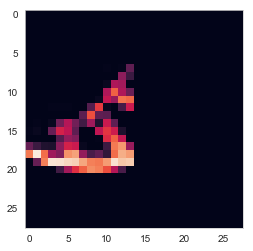

In [132]:
plt.imshow(val_x_noisy[10])

In [133]:
autoencoder4 = autoencoder
autoencoder4.fit(train_x_noisy.reshape(train_x_noisy.shape[0],28,28,1), train_x.reshape(train_x.shape[0],28,28,1),
                epochs=10,
                batch_size=2048,
                validation_data=(val_x_noisy.reshape(val_x_noisy.shape[0],28,28,1),val_x.reshape(val_x.shape[0],28,28,1)),
                callbacks=[EarlyStopping(patience=5)])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 144s 3ms/step - loss: 0.0863 - val_loss: 0.0623
Epoch 2/10
48000/48000 [==============================] - 140s 3ms/step - loss: 0.0546 - val_loss: 0.0512
Epoch 3/10
48000/48000 [==============================] - 143s 3ms/step - loss: 0.0498 - val_loss: 0.0460
Epoch 4/10
48000/48000 [==============================] - 147s 3ms/step - loss: 0.0472 - val_loss: 0.0443
Epoch 5/10
48000/48000 [==============================] - 165s 3ms/step - loss: 0.0431 - val_loss: 0.0416
Epoch 6/10
48000/48000 [==============================] - 142s 3ms/step - loss: 0.0411 - val_loss: 0.0486
Epoch 7/10
48000/48000 [==============================] - 136s 3ms/step - loss: 0.0417 - val_loss: 0.0402
Epoch 8/10
48000/48000 [==============================] - 144s 3ms/step - loss: 0.0412 - val_loss: 0.0418
Epoch 9/10
48000/48000 [==============================] - 150s 3ms/step - loss: 0.0384 - val_loss: 0.0

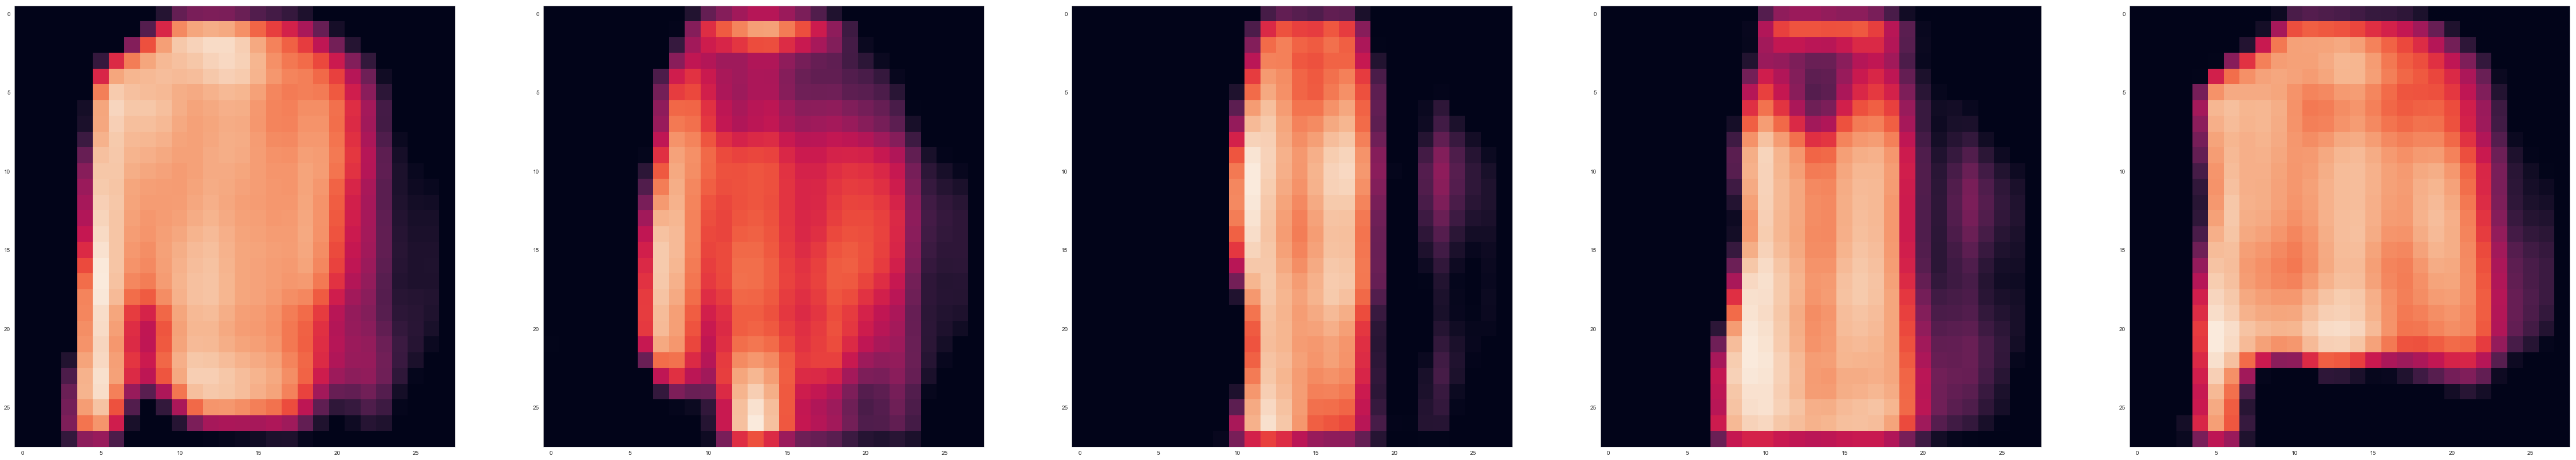

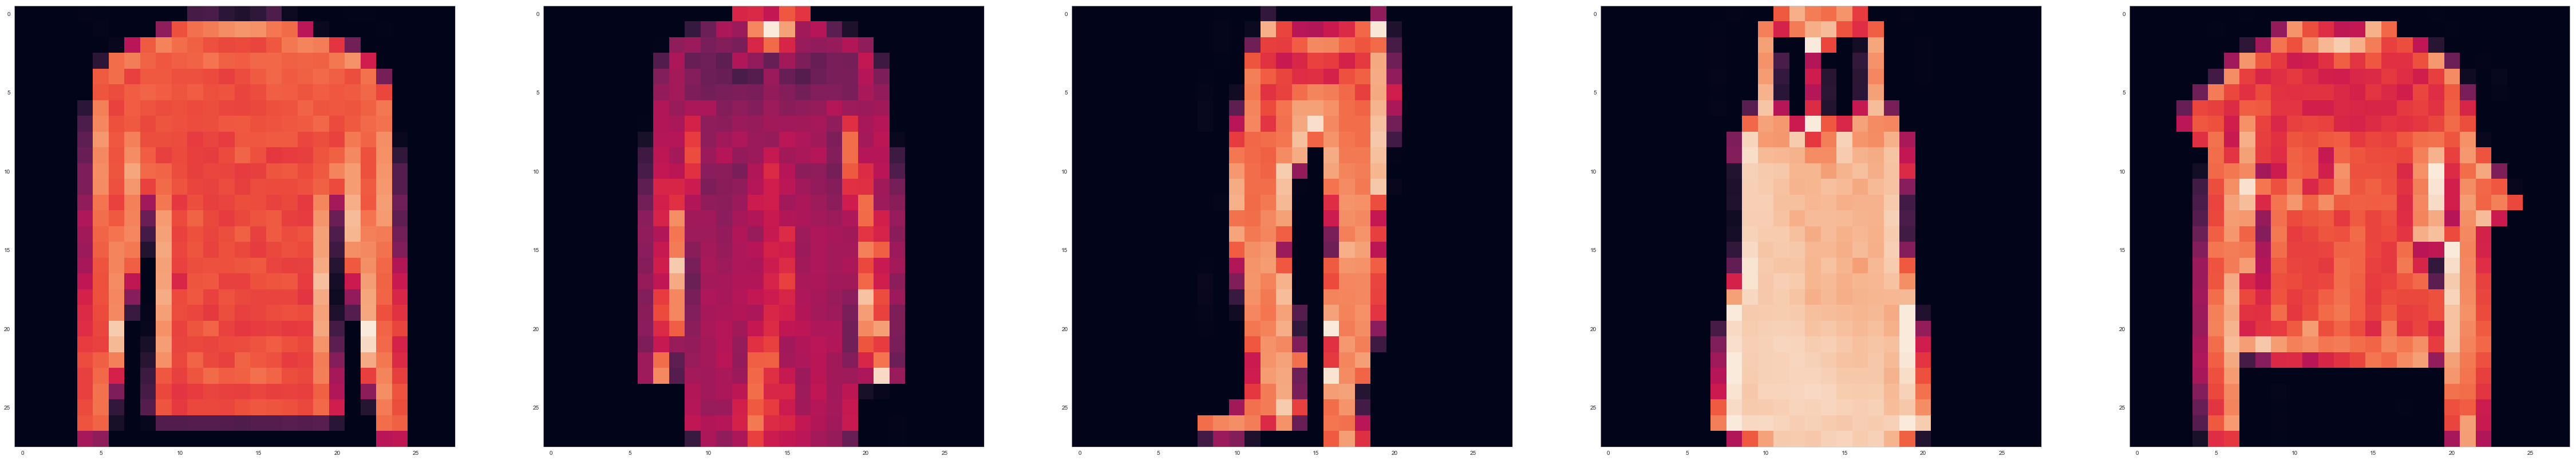

In [134]:
decoded_imgs4 = autoencoder4.predict(val_x_noisy.reshape(val_x_noisy.shape[0],28,28,1))
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(0,5):
    ax[i-5].imshow(decoded_imgs4[i].reshape(28, 28))
plt.show()

f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(0,5):
    ax[i-5].imshow(val_x[i].reshape(28, 28))
plt.show()

### Contractive auto encoder

Contracative auto encoder reduces the image reconstruction loss along with encoder gradient. The idea is, slight change in image should not affect encoded representation drastically. Hence, along with the reconstruction error, AE also tries to reduce gradient of the encoder function

In [72]:
def contractive_loss(inputs,outputs):
    loss = mse(inputs,outputs)
    loss = K.mean(loss)
    loss += .00001*K.sum(K.abs(K.gradients(encoder(inputs),inputs)))
    return loss

In [73]:
autoencoder3 = autoencoder
autoencoder3.compile(optimizer='adam', loss=contractive_loss)

In [74]:
autoencoder3.fit(train_x.reshape(len(train_x),28,28,1), train_x.reshape(len(train_x),28,28,1),
                epochs=10,
                batch_size=2048,
                validation_data=(val_x.reshape(len(val_x),28,28,1),val_x.reshape(len(val_x),28,28,1)),
                callbacks=[EarlyStopping(patience=5)])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 153s 3ms/step - loss: 1.5431 - val_loss: 0.7296
Epoch 2/10
48000/48000 [==============================] - 145s 3ms/step - loss: 0.6655 - val_loss: 0.5582
Epoch 3/10
48000/48000 [==============================] - 162s 3ms/step - loss: 0.4600 - val_loss: 0.3508
Epoch 4/10
48000/48000 [==============================] - 160s 3ms/step - loss: 0.2954 - val_loss: 0.2150
Epoch 5/10
48000/48000 [==============================] - 145s 3ms/step - loss: 0.1746 - val_loss: 0.1442
Epoch 6/10
48000/48000 [==============================] - 135s 3ms/step - loss: 0.1416 - val_loss: 0.1358
Epoch 7/10
48000/48000 [==============================] - 132s 3ms/step - loss: 0.1150 - val_loss: 0.0890
Epoch 8/10
48000/48000 [==============================] - 138s 3ms/step - loss: 0.0734 - val_loss: 0.0555
Epoch 9/10
48000/48000 [==============================] - 134s 3ms/step - loss: 0.0486 - val_loss: 0.0

In [75]:
decoded_imgs3 = autoencoder3.predict(val_x.reshape(len(val_x),28,28,1))

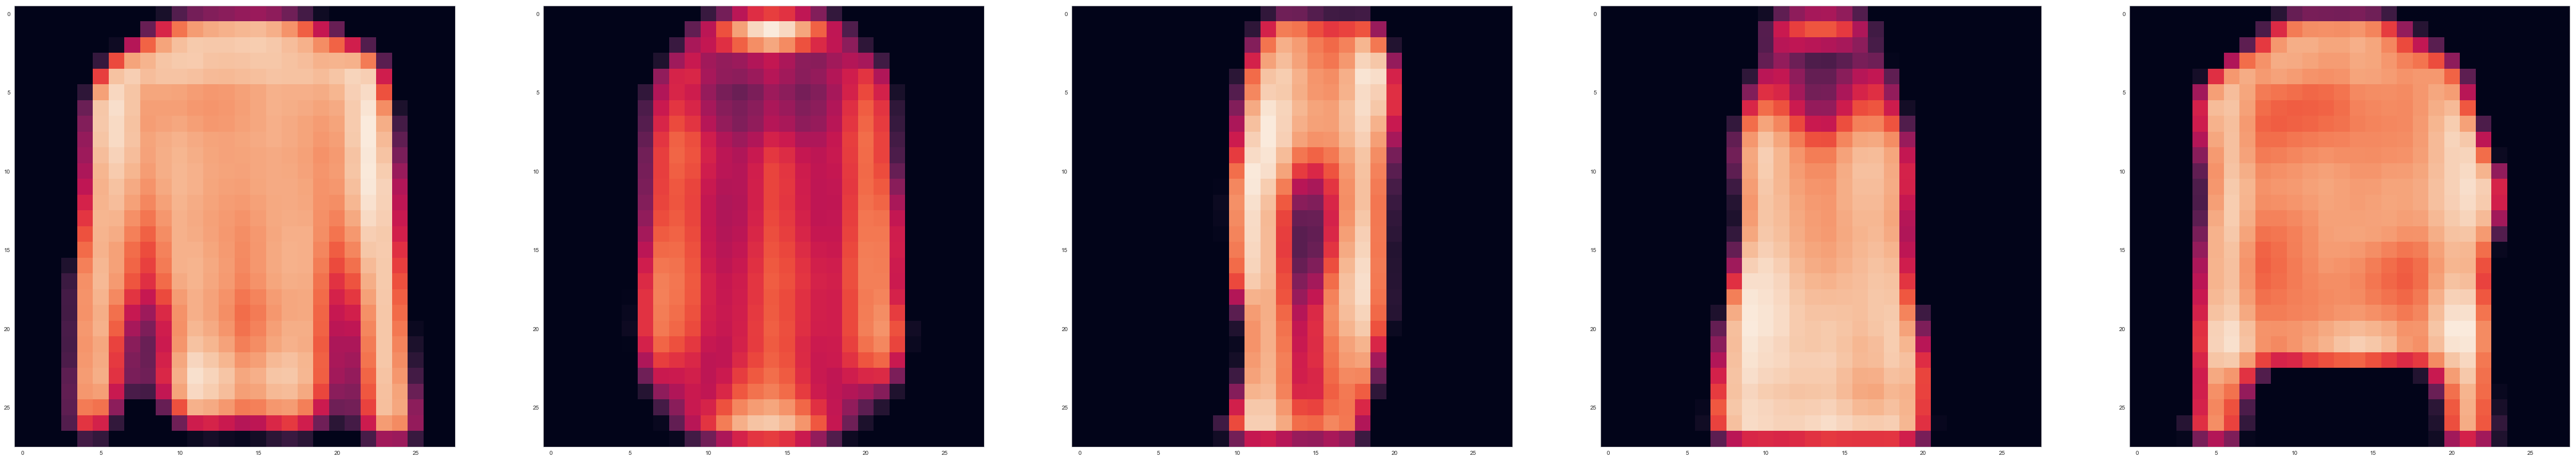

In [76]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(0,5):
    ax[i-5].imshow(decoded_imgs3[i].reshape(28, 28))
plt.show()

In [77]:
encoder3 = Model(input_img, autoencoder3.layers[5].output)
encoded_imgs3 = encoder3.predict(val_x.reshape(len(val_x),28,28,1))

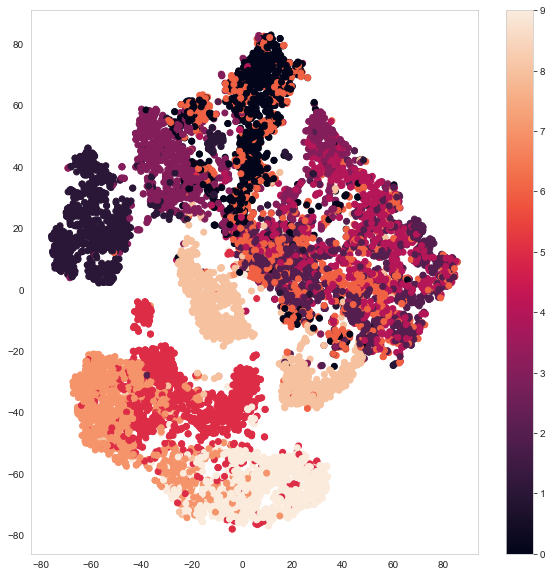

In [106]:
#reduce = umap.UMAP(random_state = 123) #just for reproducibility
embedding = tsne.fit_transform(encoded_imgs3.reshape(encoded_imgs3.shape[0],encoded_imgs3.shape[1]*encoded_imgs3.shape[2]*encoded_imgs3.shape[3]))
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0],embedding[:,1], c = val_y)
plt.colorbar()
plt.show()

It seems, contractive AE performed better in understanding the encoder representation than the vanilla convolution AE.

### Variational Auto encoder

Variational auto encoder works like a generative model, where the encoded representation comes from a sampling distribution. Hence, one can sample new values and get new image generated by the decoder. The encoder-decoder learn the relationship between image and the sampling distribution.

In [103]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [105]:
image_size = 28
original_dim = image_size * image_size

# network parameters
input_shape = (original_dim, )
intermediate_dim = 256
batch_size = 2048
latent_dim = 2
epochs = 10

In [110]:
filters = 7
kernel_size= (3,3)

In [120]:
inputs = Input(shape=(train_x.shape[1],), name='encoder_input')
x = inputs
x = Reshape((28,28,1))(x)
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(7, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
print (encoder.summary())

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

outputs = Flatten()(outputs)
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
print (decoder.summary())

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
print (vae.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 28, 28, 1)    0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 14, 14, 14)   140         reshape_5[0][0]                  
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 7, 7, 28)     3556        conv2d_33[0][0]                  
__________________________________________________________________________________________________
flatten_5 

In [121]:
reconstruction_loss = mse(inputs,outputs)
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)/(image_size * image_size)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [122]:
vae.fit(train_x,
                epochs=10,
                batch_size=2048,
                validation_data=(val_x, None),callbacks=[EarlyStopping(patience=5)])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 17s 361us/step - loss: 0.1563 - val_loss: 0.1299
Epoch 2/10
48000/48000 [==============================] - 16s 340us/step - loss: 0.1142 - val_loss: 0.0999
Epoch 3/10
48000/48000 [==============================] - 16s 339us/step - loss: 0.0924 - val_loss: 0.0858
Epoch 4/10
48000/48000 [==============================] - 16s 334us/step - loss: 0.0800 - val_loss: 0.0742
Epoch 5/10
48000/48000 [==============================] - 16s 336us/step - loss: 0.0705 - val_loss: 0.0682
Epoch 6/10
48000/48000 [==============================] - 16s 334us/step - loss: 0.0663 - val_loss: 0.0651
Epoch 7/10
48000/48000 [==============================] - 16s 340us/step - loss: 0.0632 - val_loss: 0.0611
Epoch 8/10
48000/48000 [==============================] - 16s 334us/step - loss: 0.0582 - val_loss: 0.0554
Epoch 9/10
48000/48000 [==============================] - 16s 335us/step - loss: 0.0530 - val_

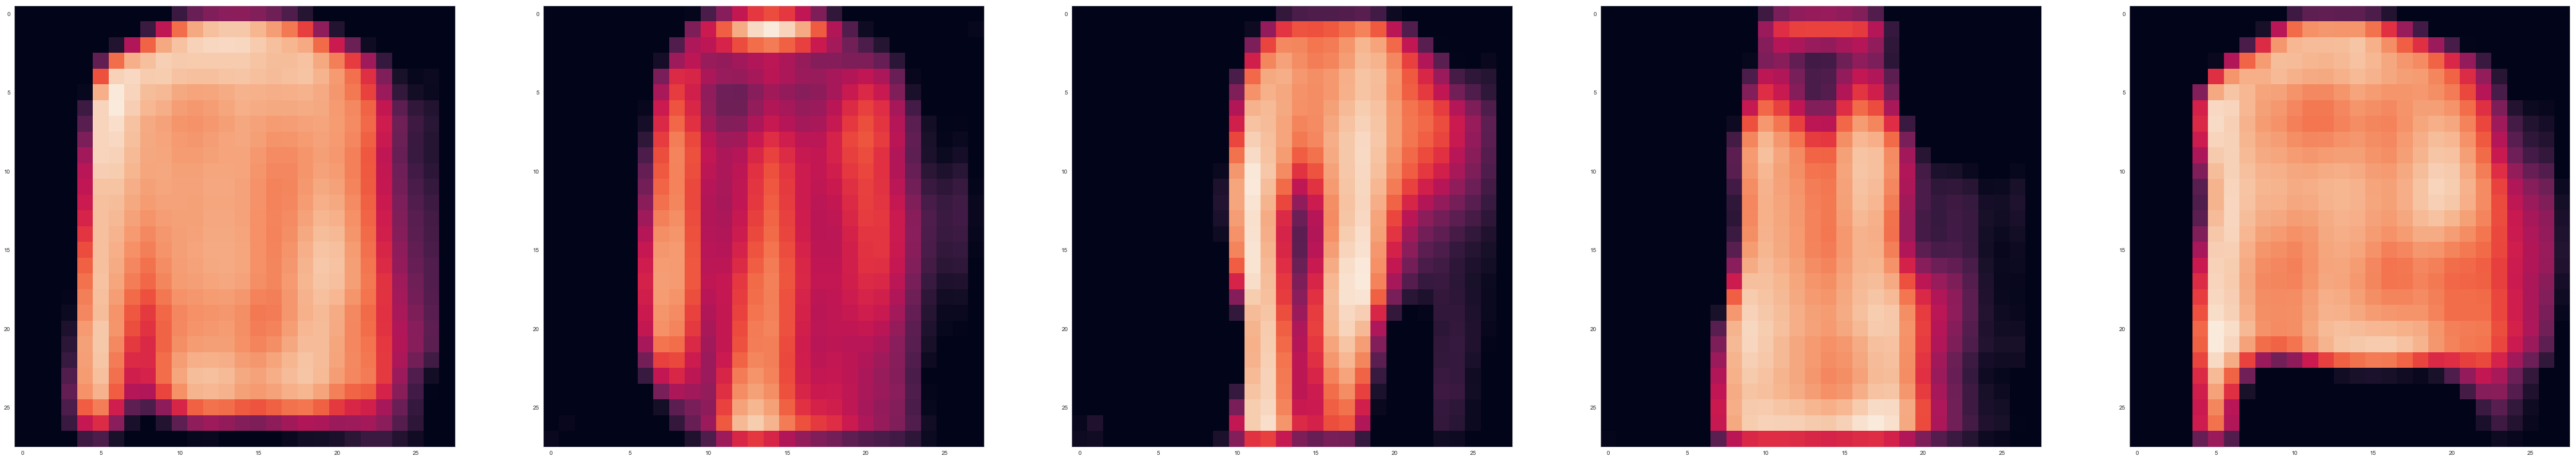

In [123]:
decoded_imgs5 = vae.predict(val_x)
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(0,5):
    ax[i-5].imshow(decoded_imgs4[i].reshape(28, 28))
plt.show()

Let us sample few points from the encoded distribution and generate new image

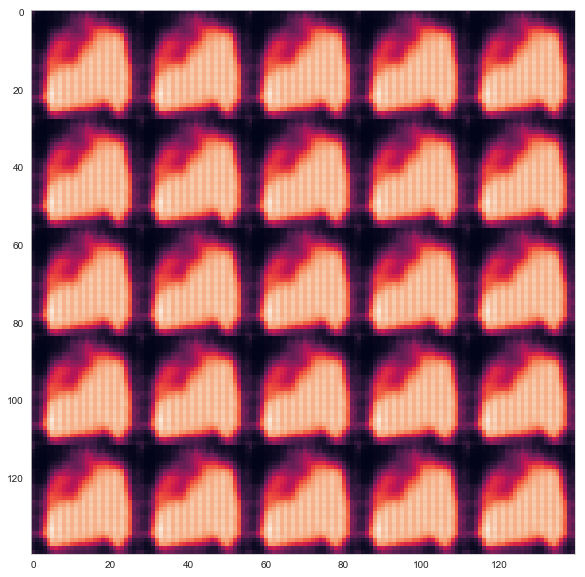

In [125]:
n = 3  # figure with 15x15 digits
fig_size = 28
epsilon_std = .01
figure = np.zeros((fig_size * n, fig_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = decoder.predict(z_sample)
        img = x_decoded[0].reshape(fig_size, fig_size)
        figure[i * fig_size: (i + 1) * fig_size,
               j * fig_size: (j + 1) * fig_size] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

All the new images are of boots

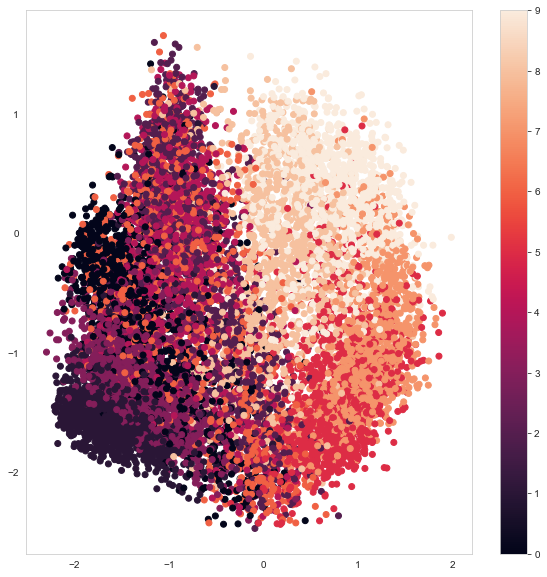

In [128]:
encoded_imgs5 = encoder.predict(val_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(encoded_imgs5[2][:, 0], encoded_imgs5[2][:, 1], c=val_y)
plt.colorbar()
plt.show()

### References - 

1. https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases
2. https://www.kaggle.com/nulldata/tsne-alternate-umap-3d-viz-on-fashion-mnist